In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from myutils import (
    get_rolling_kelly, process_data, get_historical_var
)

In [38]:
# 데이터 처리
sp500 = pd.read_csv('SP500_mine.csv')
sp500 = process_data(sp500)

kospi = pd.read_csv('KOSPI200.csv')
kospi = process_data(kospi)

In [50]:
# rf 추가
kospi['rf'] = (1 + 0.02) ** (1 / 250) - 1
sp500['rf'] = (1 + 0.02) ** (1 / 250) - 1

In [ ]:
rf = pd.read_csv('rf_data.csv')
rf.columns = ['Date', 'rf']
rf['rf'] = (1 + rf['rf']/100) ** (1 / 250) - 1
rf = rf.set_index('Date')

In [51]:
# VaR 계산
kospi_var = get_historical_var(kospi, 400, 0.05)
sp500_var = get_historical_var(sp500, 400, 0.05)

In [52]:
# Kelly 계산
rolling_kelly = get_rolling_kelly(kospi_var['Change'])
kospi_var['kelly'] = rolling_kelly

rolling_kelly = get_rolling_kelly(sp500_var['Change'])
sp500_var['kelly'] = rolling_kelly

In [53]:
sp500_var['kelly'].describe()

count    4601.000000
mean        4.406201
std         4.988386
min        -4.723982
25%         0.816588
50%         2.843416
75%         7.666478
max        32.872194
Name: kelly, dtype: float64

In [54]:
kospi_var['kelly'].describe()

count    4601.000000
mean        1.674843
std         4.747351
min        -9.159046
25%        -1.353304
50%         0.958770
75%         4.832984
max        16.971472
Name: kelly, dtype: float64

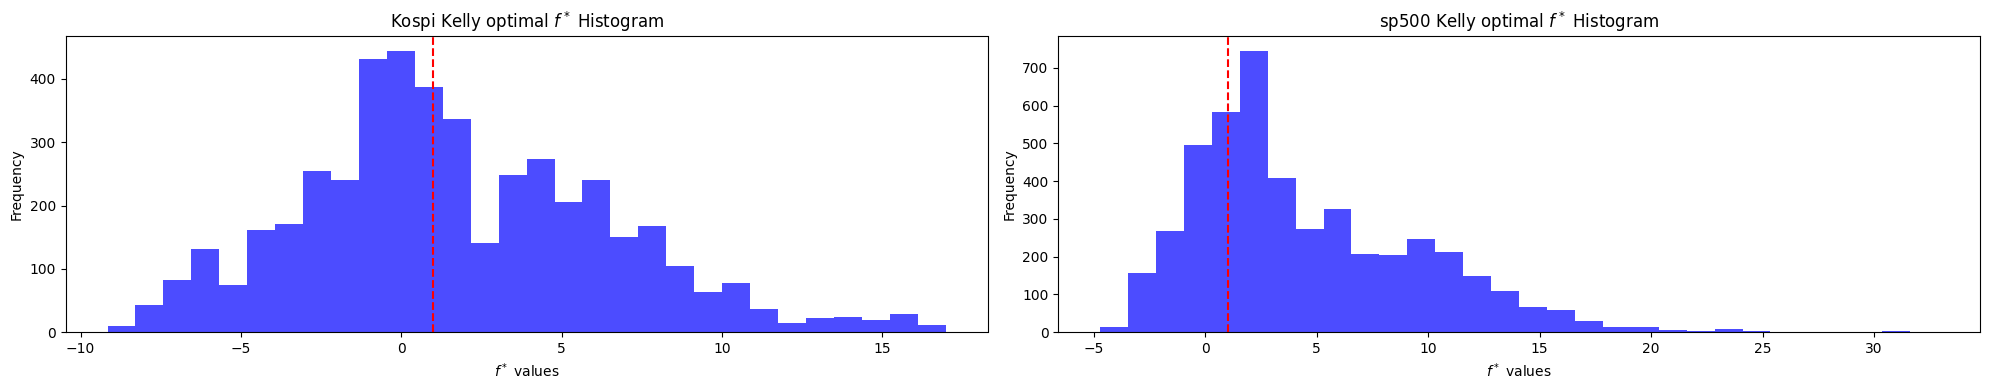

In [55]:
# 서브플롯 설정
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))

# Kospi Kelly optimal f* 히스토그램
ax[0].hist(kospi_var['kelly'], bins=30, color='blue', alpha=0.7)
ax[0].set_xlabel('$f^*$ values')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Kospi Kelly optimal $f^*$ Histogram')
ax[0].axvline(x=1, color='red', linestyle='--')

# Kospi Kelly optimal f* 히스토그램
ax[1].hist(sp500_var['kelly'], bins=30, color='blue', alpha=0.7)
ax[1].set_xlabel('$f^*$ values')
ax[1].set_ylabel('Frequency')
ax[1].set_title('sp500 Kelly optimal $f^*$ Histogram')
ax[1].axvline(x=1, color='red', linestyle='--')

plt.tight_layout()
plt.show()

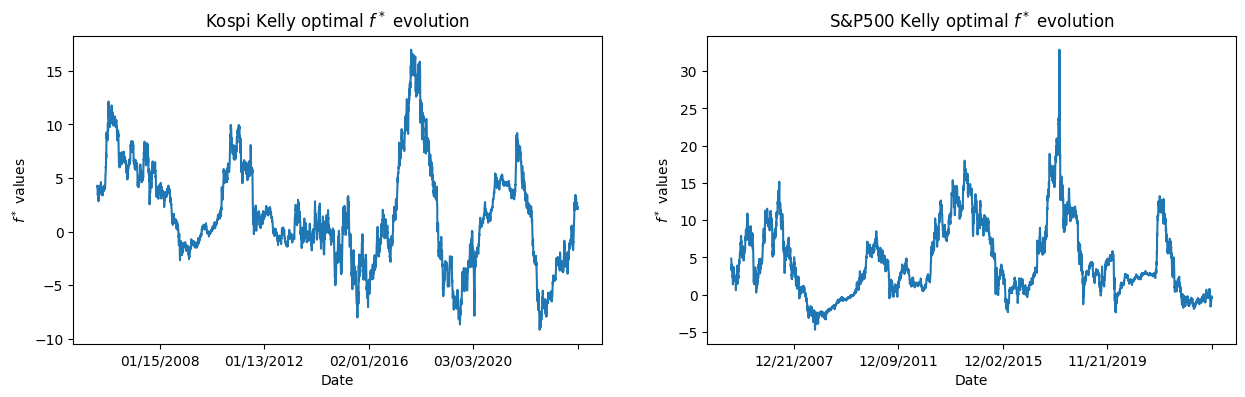

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

kospi_var['kelly'].plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kospi Kelly optimal $f^*$ evolution');

sp500_var['kelly'].plot(ax=ax[1])
ax[1].set_ylabel('$f^*$ values');
ax[1].set_title('S&P500 Kelly optimal $f^*$ evolution');

In [57]:
# kospi['daily_return'] = kospi['kelly']/100 * kospi['Change %'] + (1-kospi['kelly']/100) * kospi['rf']

In [123]:
sp500_new = sp500_var.dropna()

In [124]:
len(sp500_new)

4601

In [125]:
sp500_new.head(2)

,Price,Open,High,Low,Change %,Change,rf,VaR,kelly
Date,,,,,,,,,
08/03/2005,1245.0,1244.1,1245.9,1240.6,0.07%,0.0007,0.000079,-0.0114,4.824222
08/04/2005,1235.9,1245.0,1245.0,1235.2,-0.73%,-0.0073,0.000079,-0.0114,4.589043


In [126]:
# sp500_new['kelly'] = sp500_new['kelly'].apply(lambda x: x if x > 0 else 0)

In [127]:
sp500_new['kelly_ratio'] = sp500_new['kelly']/100

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_41542/2244008104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_new['kelly_ratio'] = sp500_new['kelly']/100


In [132]:
rebalancing_interval = 50
v0 = 100 # 100만원

portfolio = np.zeros(len(sp500_new))
equity = np.zeros(len(sp500_new))
cash = np.zeros(len(sp500_new))

for i, _row in enumerate(sp500_new.iterrows()):
    row = _row[1]
    if i == 0:
        # portfolio[0] = v0
        # cash[0] = v0*(1-row['kelly_ratio'])
        # equity[0] = v0*row['kelly_ratio']
        portfolio[0] = 1
        cash[0] = 1-row['kelly_ratio']
        equity[0] = row['kelly_ratio']
    else:
        portfolio[i] = cash[i-1] + equity[i-1]
        if i % rebalancing_interval == 0:
            equity[i] = portfolio[i] * row['kelly_ratio']
            cash[i] = portfolio[i] * (1 - row['kelly_ratio'])
        else:
            equity[i] = equity[i-1] * (1 + row['Change'])
            cash[i] = cash[i-1] * (1 + row['rf'])

In [129]:
sp500_new

,Price,Open,High,Low,Change %,Change,rf,VaR,kelly,kelly_ratio
Date,,,,,,,,,,
08/03/2005,1245.00,1244.10,1245.90,1240.60,0.07%,0.0007,0.000079,-0.0114,4.824222,0.048242
08/04/2005,1235.90,1245.00,1245.00,1235.20,-0.73%,-0.0073,0.000079,-0.0114,4.589043,0.045890
08/05/2005,1226.40,1235.90,1235.90,1225.60,-0.77%,-0.0077,0.000079,-0.0114,3.536157,0.035362
08/08/2005,1223.10,1226.40,1232.30,1222.70,-0.27%,-0.0027,0.000079,-0.0114,3.321202,0.033212
08/09/2005,1231.40,1223.10,1234.10,1223.10,0.68%,0.0068,0.000079,-0.0114,3.554048,0.035540
...,...,...,...,...,...,...,...,...,...,...
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.000079,-0.0201,-0.769535,-0.007695
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.000079,-0.0201,-0.524345,-0.005243
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.000079,-0.0201,-0.353224,-0.003532


In [131]:
for index, row in sp500_new.iterrows():
    if row['Change'] < row['VaR']:
        print(row['Change'], row['VaR'])
        sp500_new.at[index, 'kelly_ratio'] = 0

-0.0118 -0.011699999999999999
-0.0149 -0.011699999999999999
-0.0151 -0.011000000000000001
-0.0183 -0.0105
-0.0103 -0.0102
-0.0128 -0.0102
-0.011200000000000002 -0.0102
-0.0168 -0.0103
-0.0158 -0.0104
-0.0178 -0.0105
-0.011899999999999999 -0.010700000000000001
-0.0111 -0.0109
-0.0109 -0.010700000000000001
-0.013000000000000001 -0.0109
-0.013600000000000001 -0.0103
-0.0113 -0.0101
-0.0347 -0.0101
-0.011399999999999999 -0.0103
-0.0204 -0.0104
-0.013999999999999999 -0.0103
-0.0176 -0.009899999999999999
-0.010700000000000001 -0.0103
-0.013600000000000001 -0.0104
-0.0129 -0.010700000000000001
-0.014199999999999999 -0.0109
-0.012199999999999999 -0.0111
-0.019799999999999998 -0.011200000000000002
-0.0233 -0.0113
-0.016 -0.011399999999999999
-0.0126 -0.011899999999999999
-0.026600000000000002 -0.012199999999999999
-0.0296 -0.0126
-0.0182 -0.0128
-0.0139 -0.0129
-0.0235 -0.0129
-0.0169 -0.013000000000000001
-0.0256 -0.013600000000000001
-0.0264 -0.013600000000000001
-0.0294 -0.0139
-0.0143 -0.01

In [109]:
# sp500_new

In [110]:
# rebalancing_interval = 100
# v0 = 100 # 100원

# portfolio = np.zeros(len(kospi_new))
# equity = np.zeros(len(kospi_new))
# cash = np.zeros(len(kospi_new))

# for i, _row in enumerate(kospi_new.iterrows()):
#     row = _row[1]
#     # print(_row[1])
#     # print('')
#     # print(row)
#     if i == 0:
#         portfolio[0] = 1
#         cash[0] = (1-row['kelly'])
#         equity[0] = row['kelly']
#     else:
#         portfolio[i] = cash[i-1] + equity[i-1]
#         if i % rebalancing_interval == 0:
#             equity[i] = portfolio[i] * row['kelly']
#             cash[i] = portfolio[i] * (1 - row['kelly'])
#         else:
#             equity[i] = equity[i-1] * (1+row['Change %'])
#             cash[i] = cash[i-1] * (1+row['rf'])

In [133]:
# sp500_new['log_returns'] = np.log(sp500_new["Change %"])

sp500_new.loc[:, 'portfolio'] = portfolio
sp500_new.loc[:, 'equity'] = equity
sp500_new.loc[:, 'cash'] = cash
# sp500_new['strategy_returns'] = sp500_new['portfolio'] / sp500_new['portfolio'].shift(1)
# sp500_new['strategy_log_returns'] = np.log(sp500_new['strategy_returns'])
# sp500_new['strategy_cum_returns'] = sp500_new['strategy_log_returns'].cumsum()
# sp500_new['cum_returns'] = sp500_new['log_returns'].cumsum()

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_41542/2495424996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_new.loc[:, 'portfolio'] = portfolio
/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_41542/2495424996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_new.loc[:, 'equity'] = equity
/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_41542/2495424996.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [112]:
sp500_new

,Price,Open,High,Low,Change %,Change,rf,VaR,kelly,kelly_ratio,portfolio,equity,cash
Date,,,,,,,,,,,,,
08/03/2005,1245.00,1244.10,1245.90,1240.60,0.07%,0.0007,0.000079,-0.0114,4.824222,0.048242,1.000000,0.048242,0.951758
08/04/2005,1235.90,1245.00,1245.00,1235.20,-0.73%,-0.0073,0.000079,-0.0114,4.589043,0.045890,1.000000,0.047890,0.951833
08/05/2005,1226.40,1235.90,1235.90,1225.60,-0.77%,-0.0077,0.000079,-0.0114,3.536157,0.035362,0.999723,0.047521,0.951909
08/08/2005,1223.10,1226.40,1232.30,1222.70,-0.27%,-0.0027,0.000079,-0.0114,3.321202,0.033212,0.999430,0.047393,0.951984
08/09/2005,1231.40,1223.10,1234.10,1223.10,0.68%,0.0068,0.000079,-0.0114,3.554048,0.035540,0.999377,0.047715,0.952059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.000079,-0.0201,0.000000,0.000000,1.453813,0.009076,1.444869
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.000079,-0.0201,0.000000,0.000000,1.453944,0.009101,1.444983
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.000079,-0.0201,0.000000,0.000000,1.454084,0.009110,1.445098


In [114]:
sp500_new.to_csv('mid_check0430_rebal50.csv')

<Axes: xlabel='Date'>

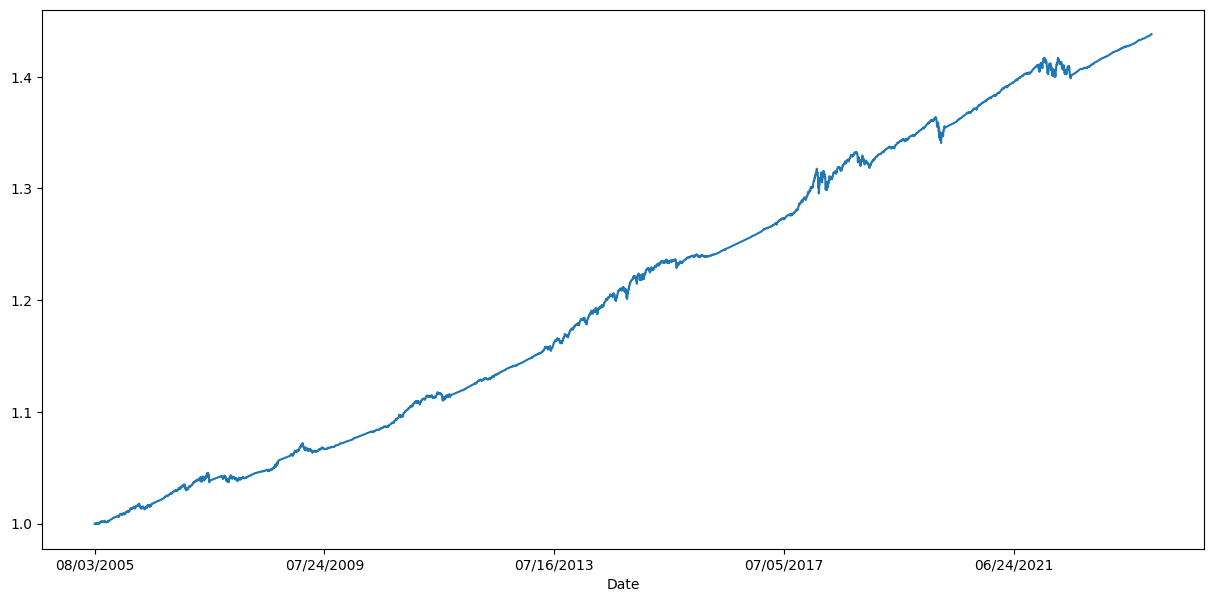

In [134]:
sp500_new['portfolio'].plot(figsize=(15, 7))

<Axes: xlabel='Date'>

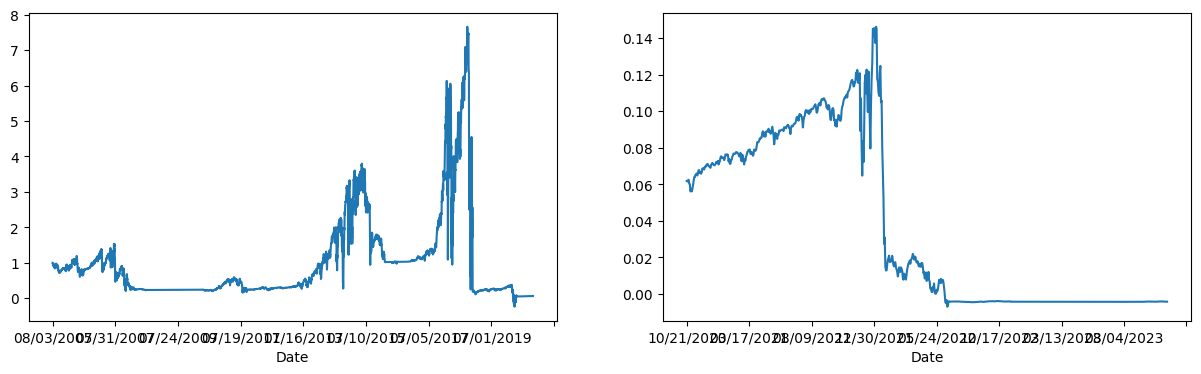

In [91]:
split_date = '10/21/2020'
before = sp500_new.loc[:split_date]
after = sp500_new.loc[split_date:]


fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

before['portfolio'].plot(ax=ax[0])

after['portfolio'].plot(ax=ax[1])